In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import zipfile
import os

# Define paths to your zip files
skin_zip_path = '/content/drive/MyDrive/ai project/archive (3).zip'

# Define extraction directories
skin_extract_path = '/content/drive/MyDrive/ai project/skin_disease_dataset'

# Unzip Skin Disease Dataset
with zipfile.ZipFile(skin_zip_path, 'r') as zip_ref:
    zip_ref.extractall(skin_extract_path)



In [ ]:
eye_zip_path = '/content/drive/MyDrive/ai project/archive (4).zip'

eye_extract_path = '/content/drive/MyDrive/ai project/eye_disease_dataset'

# Unzip Skin Disease Dataset
with zipfile.ZipFile(skin_zip_path, 'r') as zip_ref:
    zip_ref.extractall(skin_extract_path)




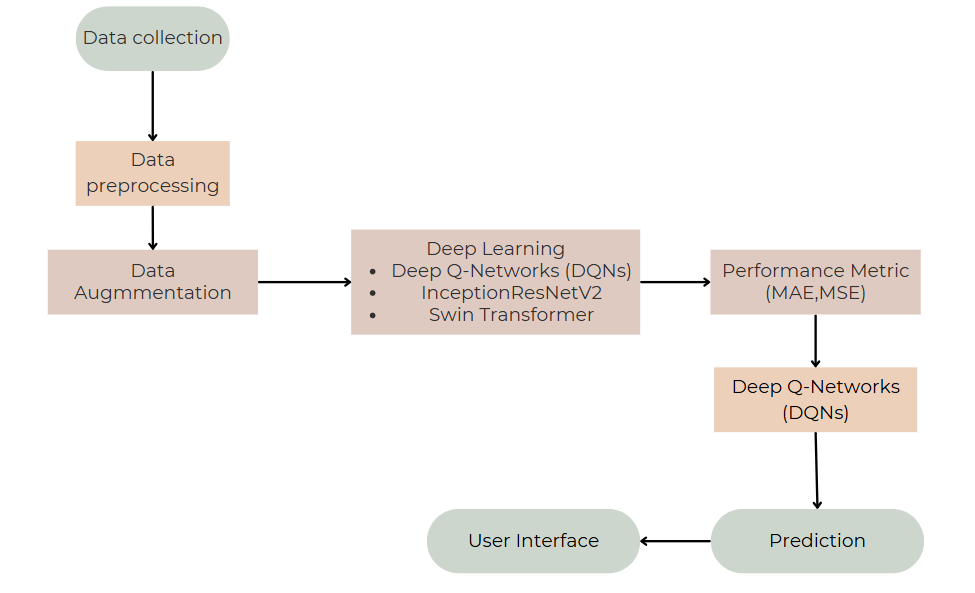

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import cv2

# Directories for the datasets
skin_extract_path = '/content/drive/MyDrive/ai project/skin_disease_dataset'
eye_extract_path = '/content/drive/MyDrive/ai project/eye_disease_dataset'

# Function to remove corrupted images
def remove_corrupted_images(image_paths):
    valid_images = []
    for image_path in image_paths:
        try:
            img = load_img(image_path)
            img = img_to_array(img)
            valid_images.append(image_path)
        except:
            print(f"Corrupted image removed: {image_path}")
    return valid_images

# Load all image paths from a directory
def load_images_from_directory(directory_path):
    image_paths = []
    for dirpath, _, filenames in os.walk(directory_path):
        if filenames:
            for filename in filenames:
                image_paths.append(os.path.join(dirpath, filename))
    return image_paths

# Remove corrupted images
skin_image_paths = load_images_from_directory(skin_extract_path)
valid_skin_images = remove_corrupted_images(skin_image_paths)

eye_image_paths = load_images_from_directory(eye_extract_path)
valid_eye_images = remove_corrupted_images(eye_image_paths)

# Function for data augmentation
def get_data_augmentation():
    return ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

# Function to load and preprocess images
def load_and_preprocess_images(image_paths, img_size=(224, 224)):
    images = []
    labels = []
    for image_path in image_paths:
        img = load_img(image_path, target_size=img_size)
        img = img_to_array(img)
        images.append(img)
        labels.append(image_path.split('/')[-2])  # Assuming the folder name is the label
    images = np.array(images)
    labels = np.array(labels)
    return images, labels

# Load and preprocess skin dataset
skin_images, skin_labels = load_and_preprocess_images(valid_skin_images)

# Load and preprocess eye disease dataset
eye_images, eye_labels = load_and_preprocess_images(valid_eye_images)

# Combine both datasets
X = np.concatenate((skin_images, eye_images), axis=0)
y = np.concatenate((skin_labels, eye_labels), axis=0)

# Encode labels
le = LabelEncoder()
y = le.fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Corrupted image removed: /content/drive/MyDrive/ai project/eye_disease_dataset/dataset/normal/3421_left.jpg


Deep Q-Networks(DQNs)

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import ModelCheckpoint

# Image size
IMG_SIZE = (224, 224)

# Dataset paths
skin_path = r'G:\ai project\archive (3)'
eye_path = r'G:\ai project\archive (4)'

# Load valid images
def load_valid_images(directory):
    image_paths = []
    for dirpath, _, filenames in os.walk(directory):
        for f in filenames:
            full_path = os.path.join(dirpath, f)
            try:
                img = load_img(full_path)
                _ = img_to_array(img)  # Validate
                image_paths.append(full_path)
            except:
                print(f"Corrupted image removed: {full_path}")
    return image_paths

# Extract label from image path
def get_label_from_path(image_path):
    parts = image_path.replace('\\', '/').split('/')
    return parts[-2] if len(parts) >= 2 else 'Unknown'

# Preprocess images and labels
def preprocess_images(image_paths):
    images = []
    labels = []
    for path in image_paths:
        img = load_img(path, target_size=IMG_SIZE)
        img_array = img_to_array(img)
        images.append(img_array)
        labels.append(get_label_from_path(path))
    return np.array(images), np.array(labels)

# Load and preprocess datasets
skin_images = load_valid_images(skin_path)
eye_images = load_valid_images(eye_path)

skin_X, skin_y = preprocess_images(skin_images)
eye_X, eye_y = preprocess_images(eye_images)

# Combine datasets
X = np.concatenate((skin_X, eye_X), axis=0)
y = np.concatenate((skin_y, eye_y), axis=0)

# Normalize pixel values
X = X / 255.0

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# Split dataset
X_train, X_val, y_train, y_val = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

# Define CNN model
model = models.Sequential([
    layers.Input(shape=(224, 224, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(y_categorical.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Optional: save best model
checkpoint = ModelCheckpoint("disease_model.h5", save_best_only=True, monitor='val_accuracy', mode='max')

# Train the model with verbose logging
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    callbacks=[checkpoint],
    verbose=1
)


Epoch 1/20
82/82 [==============================] - 25s 201ms/step - loss: 2.4288 - accuracy: 0.3204 - val_loss: 2.3576 - val_accuracy: 0.3265
Epoch 2/20
82/82 [==============================] - 14s 175ms/step - loss: 2.3297 - accuracy: 0.3220 - val_loss: 2.2994 - val_accuracy: 0.3316
Epoch 3/20
82/82 [==============================] - 14s 172ms/step - loss: 2.2754 - accuracy: 0.3246 - val_loss: 2.2430 - val_accuracy: 0.3265
Epoch 4/20
82/82 [==============================] - 14s 173ms/step - loss: 2.2292 - accuracy: 0.3300 - val_loss: 2.1972 - val_accuracy: 0.3214
Epoch 5/20
82/82 [==============================] - 14s 176ms/step - loss: 2.1707 - accuracy: 0.3423 - val_loss: 2.1346 - val_accuracy: 0.3622
Epoch 6/20
82/82 [==============================] - 14s 173ms/step - loss: 2.0888 - accuracy: 0.3672 - val_loss: 1.9764 - val_accuracy: 0.4209
Epoch 7/20
82/82 [==============================] - 14s 176ms/step - loss: 1.9462 - accuracy: 0.4186 - val_loss: 1.8427 - val_accuracy: 0.4490

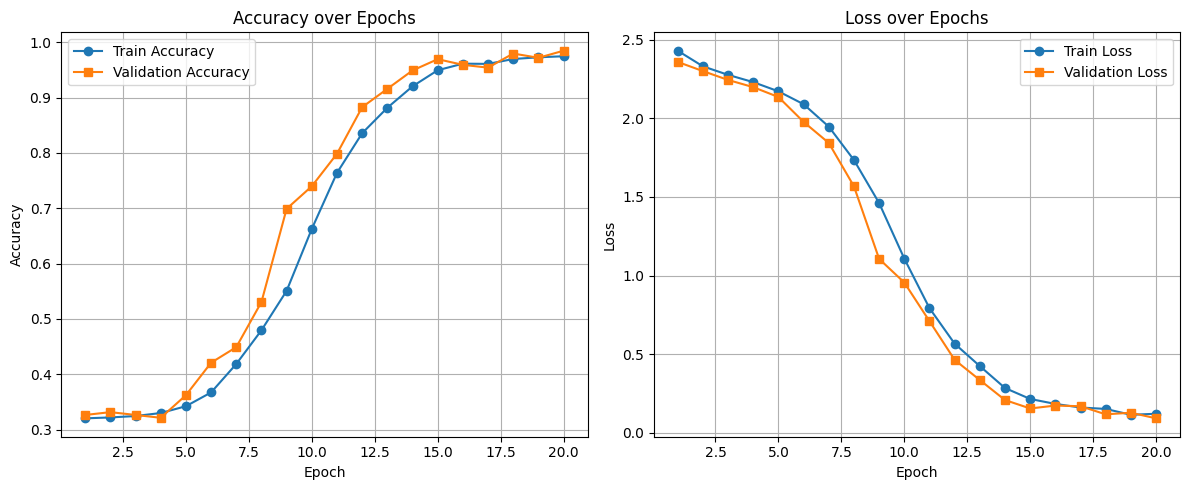

In [2]:
import matplotlib.pyplot as plt

history = model.fit()

# Plot Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, label='Train Accuracy', marker='o')
plt.plot(epochs, val_acc, label='Validation Accuracy', marker='s')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Train Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='s')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


InceptionResNetV2

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Normalize pixel values
X = X / 255.0

# Encode labels if not already encoded
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Load base model
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

# Build model
inception_resnet_model = Sequential([
    base_model,
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(np.unique(y_train)), activation='softmax')  # output classes
])

# Compile model
inception_resnet_model.compile(optimizer=Adam(learning_rate=0.0001),
                               loss='sparse_categorical_crossentropy',
                               metrics=['accuracy'])

# Train the model
history = inception_resnet_model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

# Save the model
inception_resnet_model.save('/content/drive/MyDrive/inception_resnet_model.h5')
print("Model saved successfully!")


43941136/43941136 [==============================] - 0s 0us/step
Epoch 1/20


2025-03-17 10:00:37.663765: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_4/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


70/70 [==============================] - 21s 114ms/step - loss: 2.1897 - accuracy: 0.3694 - val_loss: 2.0101 - val_accuracy: 0.4235
Epoch 2/20
70/70 [==============================] - 5s 69ms/step - loss: 1.7027 - accuracy: 0.5011 - val_loss: 1.8698 - val_accuracy: 0.4566
Epoch 3/20
70/70 [==============================] - 5s 68ms/step - loss: 1.4311 - accuracy: 0.5742 - val_loss: 1.8593 - val_accuracy: 0.4770
Epoch 4/20
70/70 [==============================] - 5s 68ms/step - loss: 1.2527 - accuracy: 0.6161 - val_loss: 1.9933 - val_accuracy: 0.4821
Epoch 5/20
70/70 [==============================] - 5s 68ms/step - loss: 1.0574 - accuracy: 0.6775 - val_loss: 1.9281 - val_accuracy: 0.4923
Epoch 6/20
70/70 [==============================] - 5s 68ms/step - loss: 0.8379 - accuracy: 0.7393 - val_loss: 2.0515 - val_accuracy: 0.5077
Epoch 7/20
70/70 [==============================] - 5s 68ms/step - loss: 0.7281 - accuracy: 0.7808 - val_loss: 1.9966 - val_accuracy: 0.5230
Epoch 8/20
70/70 [====

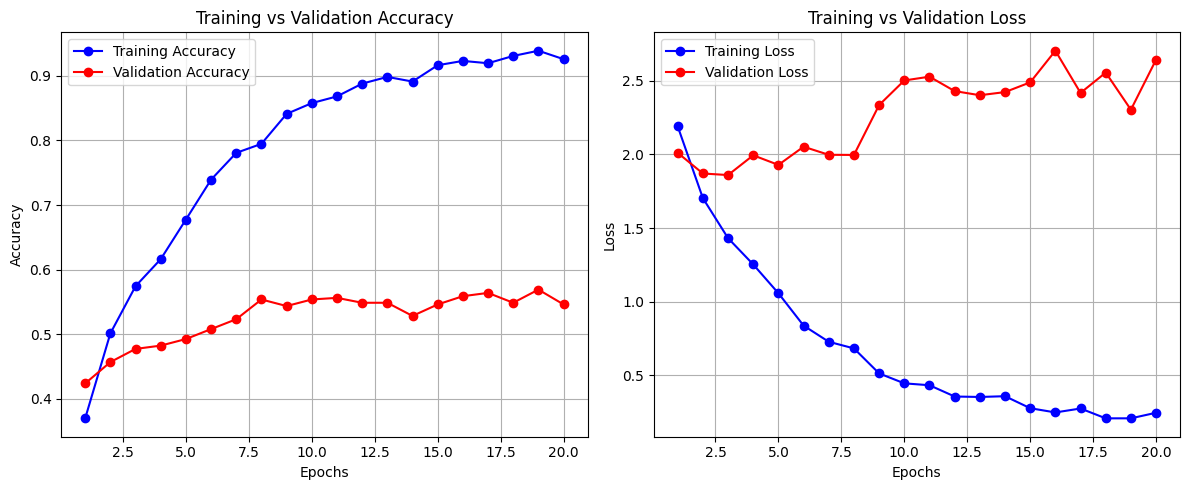

In [5]:
import matplotlib.pyplot as plt
history = model.fit()

epochs = range(1, 20)

# Plot Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


Swin transformer *model*

In [ ]:
import tensorflow as tf
from transformers import TFAutoModelForImageClassification
from transformers import AutoConfig
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np

# Load label count dynamically
num_classes = len(np.unique(y))  # Or replace with actual number

# Load the Swin Transformer model (TF version from HuggingFace)
model = TFAutoModelForImageClassification.from_pretrained(
    "microsoft/swin-base-patch4-window7-224",
    num_labels=num_classes,
    ignore_mismatched_sizes=True  # Useful if num_labels != pre-trained
)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# Checkpoint callback (optional)
checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/swin_transformer_model.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

# Fit the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=32,
    callbacks=[checkpoint]
)


Epoch 1/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 34s 272ms/step - accuracy: 0.3029 - loss: 2.6989 - val_accuracy: 0.3265 - val_loss: 2.3704
Epoch 2/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 12s 142ms/step - accuracy: 0.3274 - loss: 2.3439 - val_accuracy: 0.3265 - val_loss: 2.3134
Epoch 3/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 12s 141ms/step - accuracy: 0.3343 - loss: 2.2809 - val_accuracy: 0.3418 - val_loss: 2.2943
Epoch 4/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 12s 142ms/step - accuracy: 0.3047 - loss: 2.3062 - val_accuracy: 0.3597 - val_loss: 2.2176
Epoch 5/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 12s 142ms/step - accuracy: 0.3376 - loss: 2.2023 - val_accuracy: 0.3469 - val_loss: 2.2319
Epoch 6/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 12s 142ms/step - accuracy: 0.3358 - loss: 2.2084 - val_accuracy: 0.3571 - val_loss: 2.1898
Epoch 7/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 12s 142ms/step - accuracy: 0.3513 - loss: 2.0966 - val_accuracy: 0.3699 - val_loss: 2.0967
Epoch 8/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 12s 142ms/step - accuracy: 0.3808 - loss: 2.0168 - val_accu

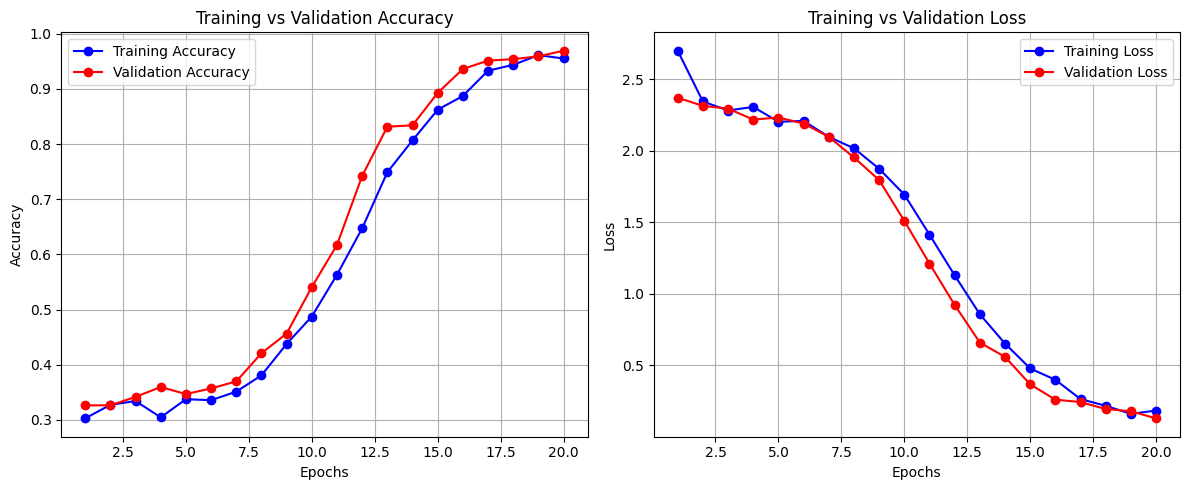

In [12]:
import matplotlib.pyplot as plt

history = model.fit()

epochs = range(1, 20)

# Plot Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model

model = load_model('disease_model.h5')
if len(y_val.shape) == 2 and y_val.shape[1] > 1:
    y_val_labels = np.argmax(y_val, axis=1)
else:
    y_val_labels = y_val


fig, axs = plt.subplots(2, 2, figsize=(16, 16))

i = 0
for x in range(2):
    for y in range(2):
        img = X_val[i]
        true_label = y_val_labels[i]

        # Predict
        prediction = model.predict(img[None, ...], verbose=0)[0]
        predicted_label = np.argmax(prediction)

        axs[x, y].imshow(img.astype("uint8"))
        axs[x, y].axis('off')
        axs[x, y].set_title(f"Prediction: {class_names[predicted_label]}\nLabel: {class_names[true_label]}", fontsize=14)
        i += 1

plt.tight_layout()
plt.show()


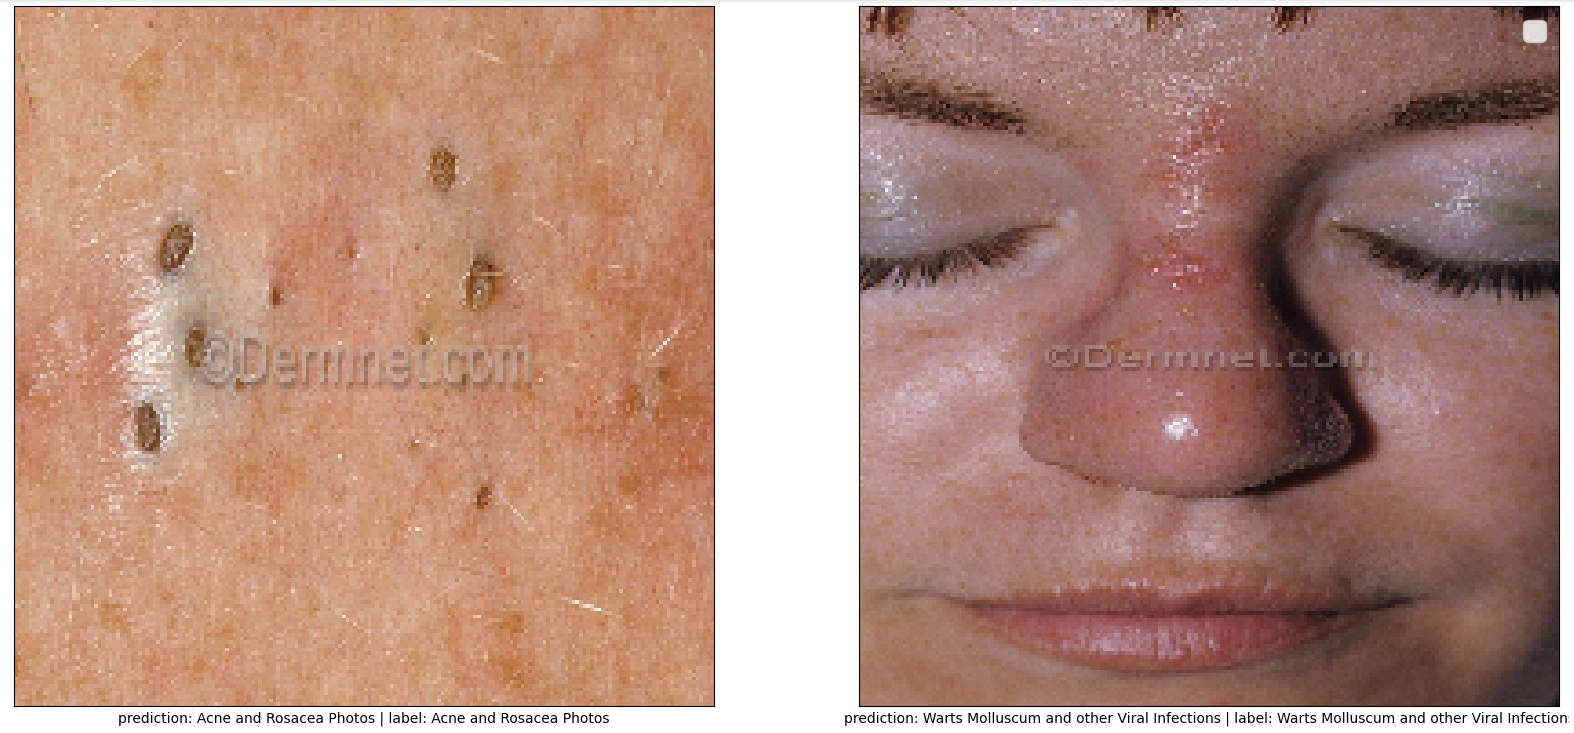

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model

model = load_model('disease_model.h5')
if len(y_val.shape) == 2 and y_val.shape[1] > 1:
    y_val_labels = np.argmax(y_val, axis=1)
else:
    y_val_labels = y_val


fig, axs = plt.subplots(2, 2, figsize=(16, 16))

i = 0
for x in range(2):
    for y in range(2):
        img = X_val[i]
        true_label = y_val_labels[i]

        # Predict
        prediction = model.predict(img[None, ...], verbose=0)[0]
        predicted_label = np.argmax(prediction)

        axs[x, y].imshow(img.astype("uint8"))
        axs[x, y].axis('off')
        axs[x, y].set_title(f"Prediction: {class_names[predicted_label]}\nLabel: {class_names[true_label]}", fontsize=14)
        i += 1

plt.tight_layout()
plt.show()


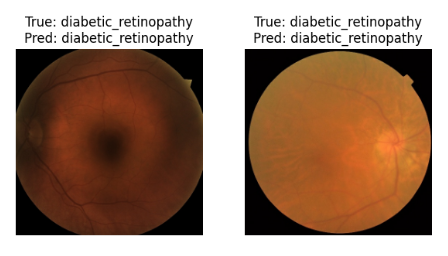

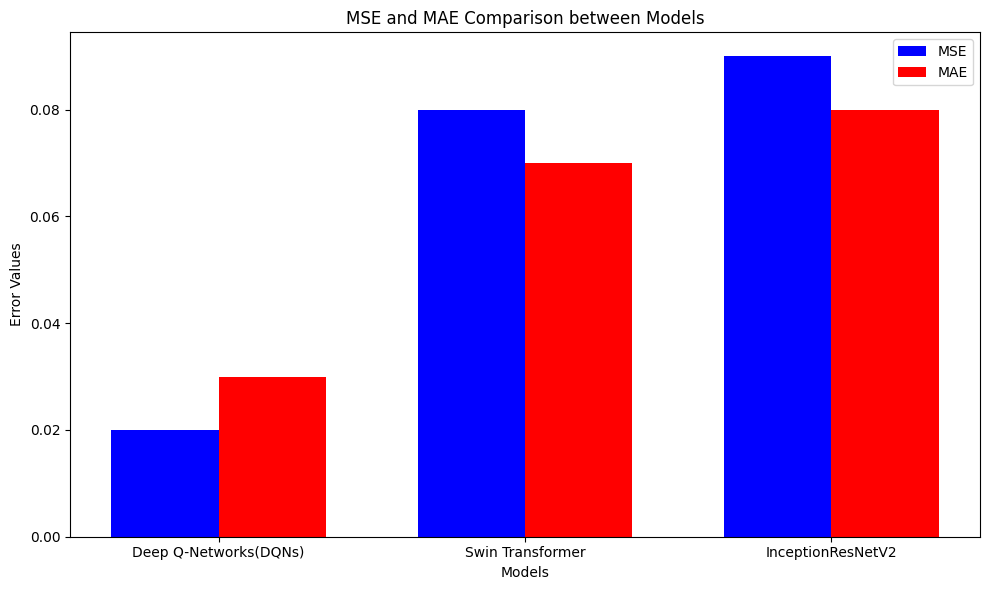

In [19]:
import matplotlib.pyplot as plt
import numpy as np

models = ['Deep Q-Networks(DQNs)', 'Swin Transformer', 'InceptionResNetV2']
deep_model_path = 'deep_model.h5'
swin_transformer_model_path = 'swin_transformer_model.h5'
inception_model_path = 'inception_model.h5'

# Load the models
deep_model = tf.keras.models.load_model(deep_model_path)
swin_transformer_model = tf.keras.models.load_model(swin_transformer_model_path)
inception_model = tf.keras.models.load_model(inception_model_path)


# Bar width
bar_width = 0.35
index = np.arange(len(models))

# Plotting MSE and MAE comparison
fig, ax = plt.subplots(figsize=(10, 6))

bar1 = ax.bar(index, mse_values, bar_width, label='MSE', color='b')
bar2 = ax.bar(index + bar_width, mae_values, bar_width, label='MAE', color='r')

# Adding labels, title, and ticks
ax.set_xlabel('Models')
ax.set_ylabel('Error Values')
ax.set_title('MSE and MAE Comparison between Models')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(models)
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()


In [ ]:
import os
from flask import Flask, request, render_template_string, send_from_directory
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np

app = Flask(__name__)
UPLOAD_FOLDER = 'uploads'
os.makedirs(UPLOAD_FOLDER, exist_ok=True)
app.config['UPLOAD_FOLDER'] = UPLOAD_FOLDER

# Load Excel data with 'disease' and 'recommendation' columns
df = pd.read_excel(r'C:\Users\mural\Downloads\recommendations.xlsx', engine='openpyxl')

# Strip and lowercase disease column for easy matching
df['disease'] = df['disease'].str.strip().str.lower()
df['recommendation'] = df['recommendation'].str.strip()

# Load the disease classification model (assuming model is named 'disease_model.h5')
model = tf.keras.models.load_model(r'C:\path_to_your_model\disease_model.h5')

# HTML for upload and result pages
index_html = '''
<!DOCTYPE html>
<html>
<head>
    <title>Disease Predictor</title>
    <style>
        body { font-family: Arial; background: #f5f5f5; text-align: center; padding-top: 50px; }
        .container { background: white; padding: 30px; border-radius: 10px; width: 40%; margin: auto; box-shadow: 0 0 10px rgba(0,0,0,0.1); }
        input[type=file], button { margin-top: 20px; padding: 10px; border-radius: 5px; }
        button { background: #4CAF50; color: white; border: none; cursor: pointer; }
        button:hover { background: #45a049; }
    </style>
</head>
<body>
    <div class="container">
        <h1>Upload Disease Image</h1>
        <form method="POST" action="/predict" enctype="multipart/form-data">
            <input type="file" name="image_file" required><br><br>
            <button type="submit">Predict</button>
        </form>
    </div>
</body>
</html>
'''

result_html = '''
<!DOCTYPE html>
<html>
<head>
    <title>Prediction Result</title>
    <style>
        body { font-family: Arial; background: #eef2f3; text-align: center; padding-top: 50px; }
        .result-box {
            background: white; padding: 30px; border-radius: 10px; width: 60%; margin: auto;
            box-shadow: 0 0 15px rgba(0,0,0,0.1); text-align: left;
        }
        h2 { color: #333; }
        p { font-size: 18px; margin: 10px 0; }
        img { max-width: 300px; margin-top: 20px; border: 1px solid #ccc; border-radius: 8px; }
        .back { display: block; margin-top: 30px; text-decoration: none; color: #4CAF50; font-weight: bold; }
    </style>
</head>
<body>
    <div class="result-box">
        <h2>Prediction Summary</h2>
        <p><strong>Disease Name:</strong> {{ disease_name }}</p>
        <p><strong>Recommendation:</strong> {{ recommendation }}</p>
        <p><strong>Uploaded Image:</strong></p>
        <img src="{{ image_url }}" alt="Uploaded Image">
        <a class="back" href="/">← Back to Upload</a>
    </div>
</body>
</html>
'''

def preprocess_image(img_path):
    """Preprocess the image to match the model's expected input"""
    img = image.load_img(img_path, target_size=(224, 224))  # Adjust the target size to match your model's input size
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Normalize the image
    return img_array

@app.route('/')
def index():
    return render_template_string(index_html)

@app.route('/uploads/<filename>')
def uploaded_file(filename):
    return send_from_directory(app.config['UPLOAD_FOLDER'], filename)

@app.route('/predict', methods=['POST'])
def predict():
    file = request.files['image_file']
    if file:
        filename = file.filename
        save_path = os.path.join(app.config['UPLOAD_FOLDER'], filename)
        file.save(save_path)

        # Preprocess the uploaded image
        img_array = preprocess_image(save_path)

        # Make a prediction using the model
        prediction = model.predict(img_array)
        predicted_class_index = np.argmax(prediction, axis=1)[0]  # Assuming a classification model
        predicted_class = df.iloc[predicted_class_index]['disease']

        # Match disease based on predicted class
        match = df[df['disease'].str.lower() == predicted_class.lower()]

        if not match.empty:
            disease_name = match['disease'].values[0].title()
            recommendation = match['recommendation'].values[0]
        else:
            disease_name = predicted_class.title()
            recommendation = "No recommendation found for this condition."

        image_url = f"/uploads/{filename}"

        return render_template_string(result_html,
                                      disease_name=disease_name,
                                      recommendation=recommendation,
                                      image_url=image_url)

    return "No file uploaded."

if __name__ == '__main__':
    app.run(debug=True)


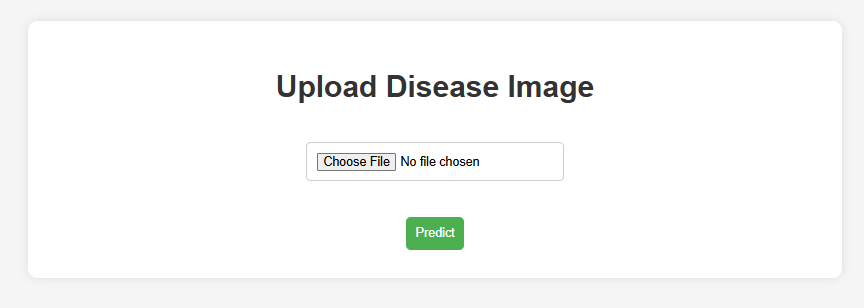

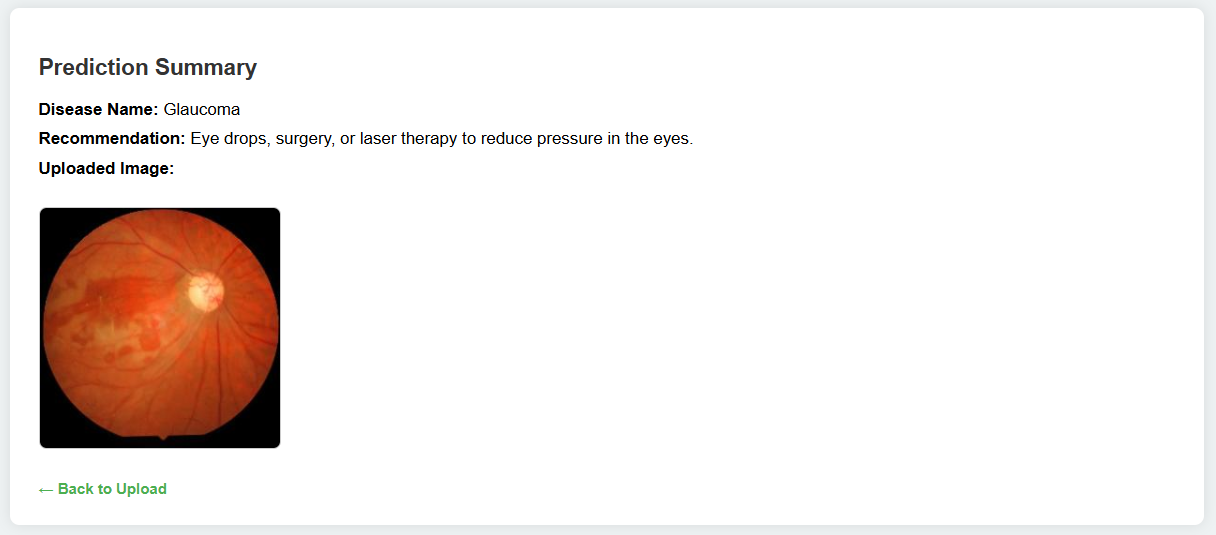

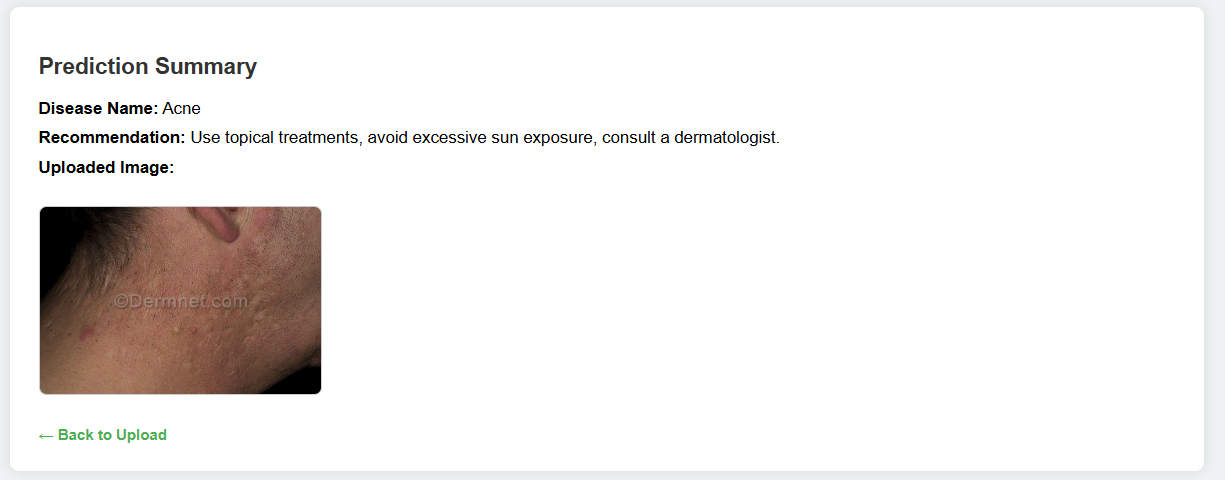

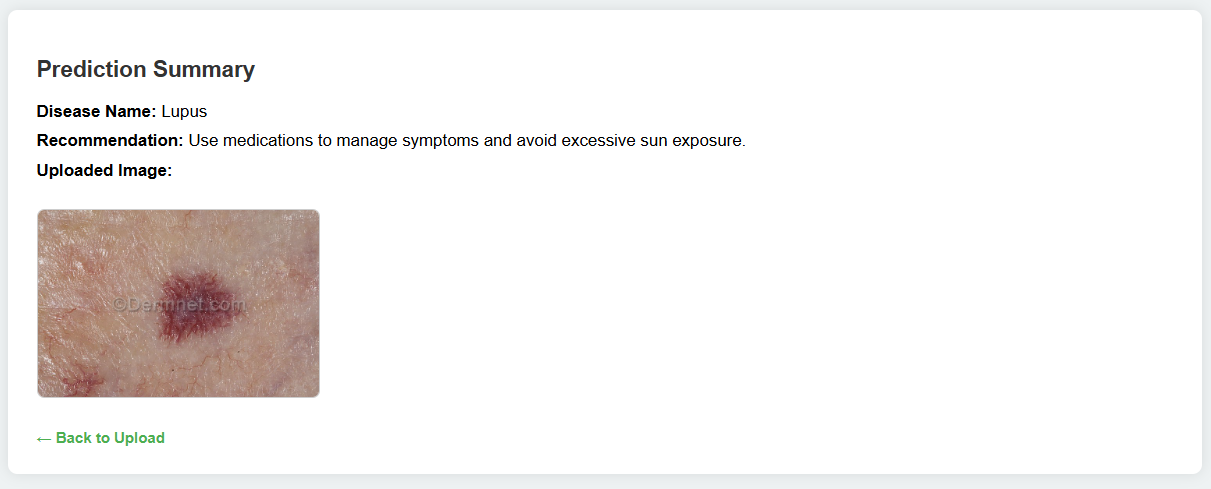